In [1]:
import json
from itertools import product
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.time import Time
from sherpa.astro.io import read_arf, read_rmf
from sherpa.astro.instrument import RSPModelNoPHA
from sherpa.astro.xspec import XSpowerlaw, XSphabs, XSTBabs, XSwabs

plt.style.use("Solarize_Light2")


def calc_ecf(rsp_model, elo, ehi, abscorr=False):
    rate = rsp_model(0)

    if abscorr:
        flux_model = rsp_model.model.parts[1]
    else:
        flux_model = rsp_model.model

    e = 0.5 * (rsp_model.rmf.e_min + rsp_model.rmf.e_max)
    flux = e * flux_model(rsp_model.rmf.e_min, rsp_model.rmf.e_max) << u.keV / u.s / u.cm**2 
    flux = flux.to(u.erg / u.s / u.cm**2).value
    
    mask_eband = np.logical_and(rsp_model.rmf.e_min >= elo, rsp_model.rmf.e_max <= ehi)
    
    return rate[mask_eband].sum() / flux[mask_eband].sum() / 1e11


# tbabs * po (NH=3e20, Γ=2.0/1.7), from Tubin-Arenas+2024
ecf_erass = {
    "1": (10.74, 10.60),
    "021": (10.26, 10.56),
    "022": (10.87, 10.54),
    "023": (1.147, 1.127),
    "02e": (7.932, 6.982),
}

ebands = {
    ## Bands from ERASS1 catalogue
    # Broad
    "1": (0.2, 2.3),
    "5": (0.5, 2.0),
    "P1": (0.2, 0.5),
    "P2": (0.5, 1.0),
    "P3": (1.0, 2.0),
    "P4": (2.0, 5.0),
    "P5": (5.0, 8.0),
    "P6": (4.0, 10.0),
    # Narrow
    "P7": (5.1, 6.1),
    "P8": (6.2, 7.1),
    "P9": (7.2, 8.2),
    ## From upper-limit server (Tubin-Arenas+2024)
    "021": (0.2, 0.6),
    "022": (0.6, 2.3),
    "023": (2.3, 5.0),
    "02e": (0.2, 5.0),
    ## Standard
    "SOFT": (0.5, 2.0),
    "HARD": (2.0, 10.0),
}

epochs = {
    "e1": ("2019-10-17", None),
}

data_path = Path("data", "erosita")

In [2]:
# Source model, as in Rossen+2016
po = XSpowerlaw("po")
po.PhoIndex = 1.7

galabs = XSphabs("galabs")
# galabs = XSwabs("galabs")
# galabs = XSTBabs("galabs")
galabs.nH = 3e20 / 1e22

model = galabs * po

In [3]:
arfs_path = data_path / "arfs"
rmfs_path = data_path / "rmfs"

lognhs = np.linspace(19, 22, num=31)
gammas = np.linspace(1.4, 2.2, num=9)

ecf = {
    "lognh": lognhs.tolist(),
    "gamma": gammas.tolist(),
}
        
for epoch in epochs:
    ecf[epoch] = {}

    rmf = read_rmf(str(rmfs_path / "onaxis_tm0_rmf_2023-01-17.fits"))
    arf = read_arf(str(arfs_path / "onaxis_tm0_arf_filter_2023-01-17.fits"))

    for eband, (elo, ehi) in ebands.items():
        ecf[epoch][eband] = {}

        rsp_model = RSPModelNoPHA(arf, rmf, model)

        model_ecfs = []
        for lognh, gamma in product(lognhs, gammas):
            rsp_model.pars[0].val = 10**lognh / 1e22
            rsp_model.pars[1].val = gamma

            model_ecfs.append(calc_ecf(rsp_model, elo, ehi))

        ecf[epoch][eband] = np.reshape(model_ecfs, (len(lognhs), len(gammas))).tolist()


with open(data_path / "ecfs.json", "w") as fp:
    json.dump(ecf, fp, indent=4)

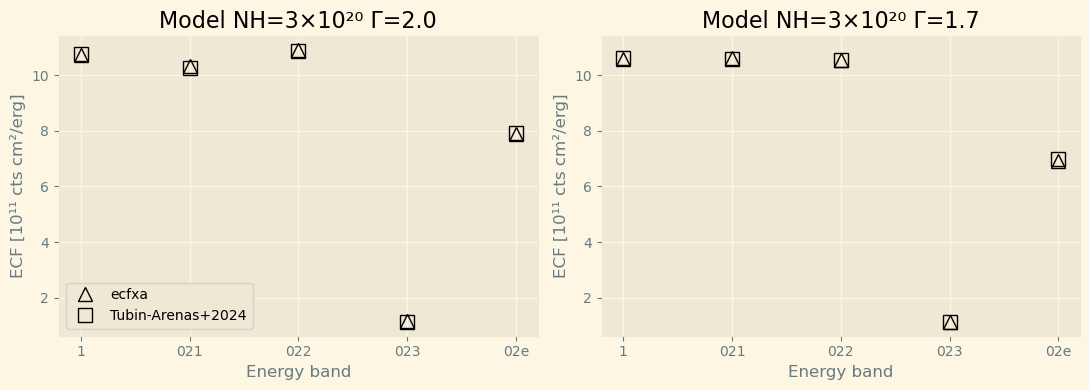

In [4]:
idx_lognh = 15  # ~3e20
gamma_vals = {
    6: 2.0,
    3: 1.7,
}
    

plt.figure(figsize=(11,4))

ax = None
for i, (idx_gamma, gamma) in enumerate(gamma_vals.items(), start=1):
    ax = plt.subplot(1,2,i, sharey=ax)
    plt.title(f"Model NH=3×10²⁰ Γ={gamma}")

    for eband, values in ecf_erass.items():
        if eband == "1":
            label1 = "ecfxa"
            label2 = "Tubin-Arenas+2024"
        else:
            label1 = "_ecfxa"
            label2 = "_Tubin-Arenas+2024"
            
        plt.plot(eband, ecf["e1"][eband][idx_lognh][idx_gamma], "k^", ms=10, markerfacecolor="none", label=label1)
        plt.plot(eband, values[i -1], "ks", ms=10, markerfacecolor="none", label=label2)

    plt.xlabel("Energy band")
    plt.ylabel("ECF [10¹¹ cts cm²/erg]")

    if i == 1:
        plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

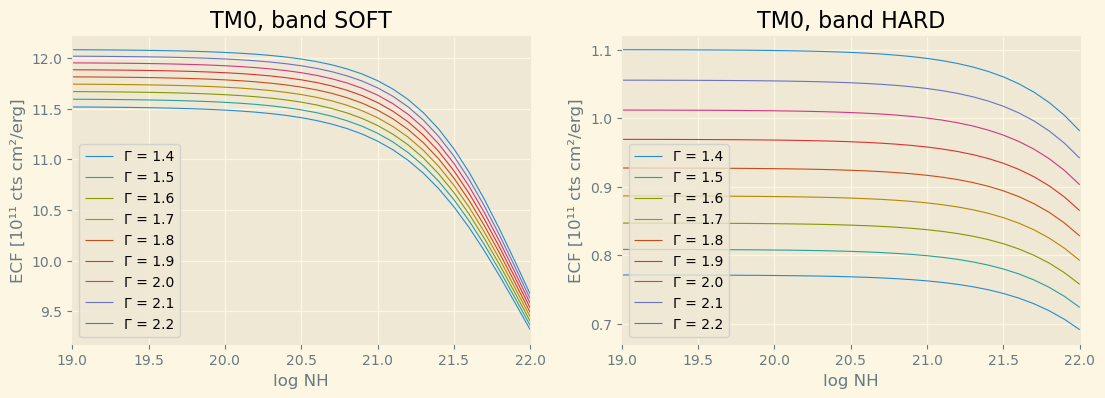

In [5]:
plt.figure(figsize=(13,4))

band = "SOFT"
plt.subplot(121)
plt.title(f"TM0, band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [ecf["e1"][band][idx_lognh][i] for idx_lognh, _ in enumerate(ecf["lognh"])]
    plt.plot(ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")

band = "HARD"
plt.subplot(122)
plt.title(f"TM0, band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [ecf["e1"][band][idx_lognh][i] for idx_lognh, _ in enumerate(ecf["lognh"])]
    plt.plot(ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")

plt.show()

In [6]:
arfs_path = data_path / "arfs"
rmfs_path = data_path / "rmfs"

lognhs = np.linspace(19, 22, num=31)
gammas = np.linspace(1.4, 2.2, num=9)

ecf = {
    "lognh": lognhs.tolist(),
    "gamma": gammas.tolist(),
}
        
for epoch in epochs:
    ecf[epoch] = {}

    rmf = read_rmf(str(rmfs_path / "onaxis_tm0_rmf_2023-01-17.fits"))
    arf = read_arf(str(arfs_path / "onaxis_tm0_arf_filter_2023-01-17.fits"))

    for eband, (elo, ehi) in ebands.items():
        ecf[epoch][eband] = {}

        rsp_model = RSPModelNoPHA(arf, rmf, model)

        model_ecfs = []
        for lognh, gamma in product(lognhs, gammas):
            rsp_model.pars[0].val = 10**lognh / 1e22
            rsp_model.pars[1].val = gamma

            model_ecfs.append(calc_ecf(rsp_model, elo, ehi, abscorr=True))

        ecf[epoch][eband] = np.reshape(model_ecfs, (len(lognhs), len(gammas))).tolist()


with open(data_path / "abscorr_ecfs.json", "w") as fp:
    json.dump(ecf, fp, indent=4)

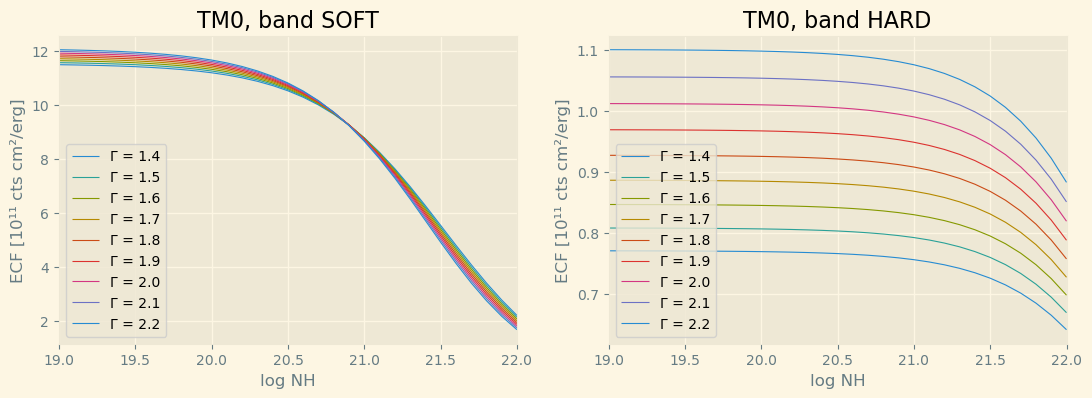

In [7]:
plt.figure(figsize=(13,4))

band = "SOFT"
plt.subplot(121)
plt.title(f"TM0, band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [ecf["e1"][band][idx_lognh][i] for idx_lognh, _ in enumerate(ecf["lognh"])]
    plt.plot(ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")

band = "HARD"
plt.subplot(122)
plt.title(f"TM0, band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [ecf["e1"][band][idx_lognh][i] for idx_lognh, _ in enumerate(ecf["lognh"])]
    plt.plot(ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")

plt.show()